# TMA4205 - Assignment 3

## Task 1

I wish to solve the 2D Poisson equation 

$$\nabla u = f(x,y) \quad \mathrm{for} \quad 0<x,y<1 \\ u = 0 \quad \mathrm{on \: the \: boundary} $$

with a multigrid V-cycle method. This will have the pseudocode


![title](multigridVcycle.pdf)


as described in the book _Iterative Methods for Sparse Linear Systems_ by Saad.

To do this, I start by taking use of the 5-point scheme

$$ U_{i+1, j} + U_{i-1, j} + U_{i, j+1} + U_{i, j-1} - 4U_{i,j}= h^2 f_{i,j} $$

which can be written as a system of equations $\mathbf{A} \mathbf{u} = h^2 \mathbf{f}$. The $\mathbf{A}$ matrix can be implemented as below.

In [2]:
import numpy as np
import scipy.io
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [3]:
def five_point(N):
    u = np.eye(N**2)
    Au = 4 * u

    Au[:,:-N] = Au[:,:-N] - u[:,N:]
    Au[:-N,:] = Au[:-N,:] - u[N:,:]

    diag = np.ones(N)
    diag[-1] = 0
    np.fill_diagonal(u, diag)

    Au[1:,:] = Au[1:,:] - u[:-1,:]

    diag = np.ones(N)
    diag[0] = 0
    np.fill_diagonal(u, diag)

    Au[:-1,:] = Au[:-1,:] - u[1:,:]

    return -Au

As seen above, the five-point stencil is a tridiagonal block matrix. Expanding this to include the $u$-matrix, as to get the whole left hand side of the equation, we can implement it as such

In [4]:
def lhs(u):
    Au = 4 * u
    Au[1:,:] = Au[1:,:] - u[:-1,:]
    Au[:-1,:] = Au[:-1,:] - u[1:,:]
    Au[:,1:] = Au[:,1:] - u[:,:-1]
    Au[:,:-1] = Au[:,:-1] - u[:,1:]
    return Au

As I wish to solve this system of equations with a V-cycle multigrid method, I start by implementing a weighted Jacobi method to use for the pre- and postsmoothings. This iterative method takes the form

$$u_{j+1} = [(1-\omega)I + \omega D^{-1}(D-A)]u_j + \omega D^{-1} f = J_{\omega} u_j + f_{\omega}.$$

Since for the five-point method the diagonal matrix will be $D = \frac{1}{4}I$, I can rewrite $J_{\omega}$ as

$$ J_\omega = I - \frac{1}{4} \omega A,$$

and the implementation can be done as such

In [5]:
def jacobi(u0, rhs, w, nu):
    # Initializing variables
    rhs = rhs
    n = u0.shape[0]
    Au = lhs(u0)

    # Calculating u_{j+1} = (I - 1/4 w A)u_j + f_w
    for i in range(nu):
        u0 = u0 + (w * 0.25) * (rhs - lhs(u0))

    return u0

The next step is then to define the function that finds the residual as simply

In [6]:
def residual(u,rhs):
    return rhs - lhs(u)

Then we wish to define the function that makes the grid coarser, which we call the restriction function. The idea is to go from a large $(h,h)$-matrix to a smaller $(H, H)$-matrix, where $H = \frac{h+1}{2}-1$. This is done as shown in the figure below, where one uses central difference to weight each element correctly.

![title](restriction.png)

When implemented this will look like

In [7]:
def restriction(rh):
    h = rh.shape[0]     # Original grid size
    H = (h+1)/2 - 1     # New coarser grid size

    # Checks if H is a whole number
    if H.is_integer():
        H = int(H)
    else:
        print('\nerror as H is', H, '\n')
        return 0

    # Initializing smaller grid
    rH = np.zeros((H, H))
    rectangle = np.zeros((H, h))

    # Transforming a (h x h)-matrix into a (H x h)-matrix
    for i in range(H):
        rows = rh[2*i:2*i+3, :]
        row = np.zeros(h)
        row += (rows[0] + 2*rows[1] + rows[2])
        rectangle[i] += row

    # Transforming a (H x h)-matrix into (H x H)-matrix
    for i in range(H):
        cols = rectangle[:, 2*i:2*i+3]
        rH[:,i] += (cols[:,0] + 2*cols[:,1] + cols[:,2])/4
    return rH

Then the multigrid method will check if this is the smallest matrix allowed. If it is then we would wish to solve this as such 

In [8]:
def solve_direct(rhs):
    if rhs.shape[0] == 1:
        return rhs/4
    else:
        rhs = np.asarray(rhs).reshape(-1)
        N = rhs.shape[0]
        n = int(np.sqrt(N))
        A = sparse.csr_matrix(five_point(int(n)))
        u = (spsolve(A,rhs)).reshape((n,n))
        return u

If not, then we will recursively restart the function, and restrict the matrix once again. Once we've reached a matrix that is possible to solve, we return the $u$ obtained by the solve_direct() function. Now we wish to get our solution in the original grid size again. This is done by an interpolation function that expands a matrix as such

![title](interpolation.png)

Where the value of a matrix entry that lies between to red dots is their average, a matrix entry along the edge is the avergage value of the red dots it lies next to and zero, and the entries that lay in the middle of four points is calculated by taking the average value of all those points. This results in an interpolation function that looks like this

In [9]:
def interpolation(d2h):
    H = d2h.shape[0]
    h = 2*(H+1)-1

    # Initializing the finer matrix
    d2 = np.zeros((h, h))

    for i in range(1,H+1):
        # Initializing variables
        row = d2[2*i-1,:]
        row[1::2] = d2h[i-1,:]
        col = d2[:, 2*i-1]
        col[1::2] = d2h[:,i-1]

        # Finding averages for the rows
        small_row = row[1::2]
        row[2:-2:2] = [(a+b)/2 for a, b in zip(small_row[::], small_row[1::])]

        # Finding averages for the columns
        small_col = col[1::2]
        col[2:-2:2] = [(a+b)/2 for a, b in zip(small_col[::], small_col[1::])]

    for i in range(H):
        # Finding averages for the midpoints
        midpoint_row = d2[2*i,:]
        upper_row = d2[2*i-1,:]
        lower_row = d2[2*i+1,:]
        small_upper_row = upper_row[1::2]
        small_lower_row = lower_row[1::2]
        midpoint_row[2:-2:2] = [(a+b+c+d)/4 for a, b, c, d in zip(small_upper_row[::], small_upper_row[1::], small_lower_row[::], small_lower_row[1::])]

    # Calculating the edge values
    d2[0, :] = d2[1, :] / 2
    d2[-1, :] = d2[-2, :] / 2
    d2[:, 0] = d2[:, 1] / 2
    d2[:, -1] = d2[:, -2] / 2

    return d2

Then lastly, one has to smooth the resulting matrix again, using the weighed Jacobi method we've already implemented. Then the multigrid function can be combined, and we get a the function

In [10]:
def mgv(u0, rhs, nu1, nu2, level, max_level):
    """
    mgv(u0, rhs, nu1, nu2, level, max_level)
    performs one multi-grid V-cycle for the 2D Poisson problem
    on the unit square [0,1]x[0,1] with initial guess u0 and
    right-hand side rhs
    input: u0         - initial guess ((N-1)x(N-1) matrix
                        representing internal nodes)
           rhs        - right-hand side ((N-1)x(N-1) matrix)
           nu1        - number of presmoothings
           nu2        - number of postsmoothings
           level      - current level
           max_level  - total number of levels
    """
    # Checks if we are to solve the small problem directly
    if level == max_level:
        return solve_direct(rhs)
    
    else:
        Nh = u0.shape[0]+1
        u = jacobi(u0, rhs, 0.8, nu1)
        rh = residual(u, rhs)
        r2h = restriction(rh)
        N2h = Nh//2
        d2h = mgv(np.zeros((N2h-1,N2h-1)), r2h, nu1, nu2, level+1, max_level)
        dh = interpolation(d2h)
        u = u + dh
        u = jacobi(u, rhs, 0.8, nu2)
    return u

Then we need a way to look at the solution, so I implement this plotting function.

In [13]:
def plot(u, rhs, N, iterations):
    x = np.linspace(0,1,N)
    y = np.linspace(0,1,N)
    X,Y = np.meshgrid(x, y)
    
    res = residual(u, rhs)
    
    fig = plt.figure(figsize=plt.figaspect(0.2))
    
    ax = fig.add_subplot(1, 3, 1, projection='3d')
    ax.plot_surface(X, Y, u, cmap=cm.coolwarm, rstride=1, cstride=1, linewidth=0)
    ax.view_init(azim=10)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('u after %d Cycle(s) with N = %d' % (iterations, N))
    
    ax = fig.add_subplot(1, 3, 2, projection='3d')
    ax.plot_surface(X, Y, lhs(u), cmap=cm.coolwarm, rstride=1, cstride=1, linewidth=0)
    ax.view_init(azim=10)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Au after %d Cycle(s) with N = %d' % (iterations, N))
    
    ax = fig.add_subplot(1, 3, 3, projection='3d')
    ax.plot_surface(X, Y, res, cmap=cm.coolwarm, rstride=1, cstride=1, linewidth=0)
    ax.view_init(azim=10)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Residual after %d Cycle(s) with N = %d' % (iterations, N))
    

And lastly the main function. 

In [14]:
def task1a(L, nu1, nu2, tol, max_iter):
    f = lambda x,y: np.sin(x*y)
    N = 2**L-1
    x = np.linspace(0,1,N)
    y = np.linspace(0,1,N)
    rhs = np.zeros((N,N))
    u = np.random.rand(N,N)

    for i in range(N):
        for j in range(N):
            rhs[i,j] = f(x[i],y[j])

    r0 = np.linalg.norm(residual(u, rhs), 2)
    r = r0
    iterations = 0
    
    plot(u, rhs, N, iterations)

    while r/r0 > tol and max_iter > iterations:
        u = mgv(u, rhs, nu1, nu2, 0, L-1)
        r = np.linalg.norm(residual(u, rhs), 2)
        iterations += 1
        plot(u, rhs, N, iterations)

    plt.show()

Now, if we look at the multigrid V-cycle after the first five iterations, this will look like

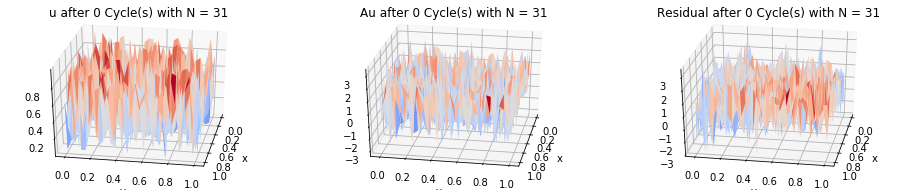

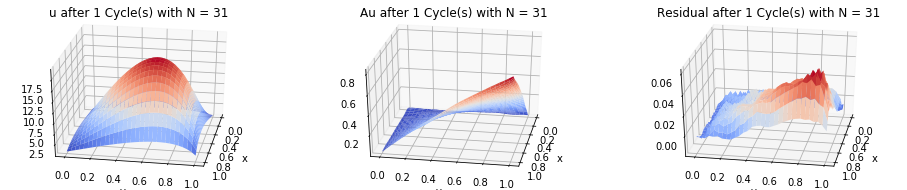

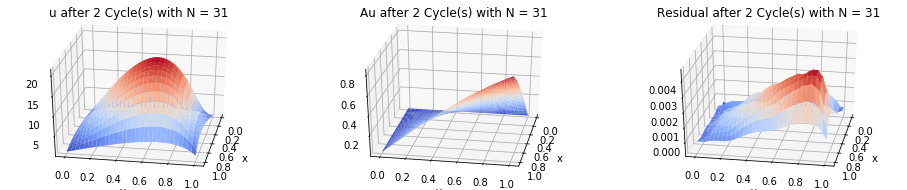

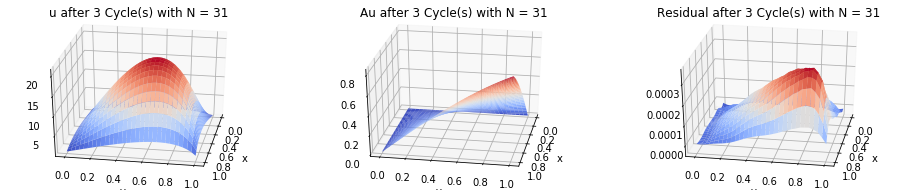

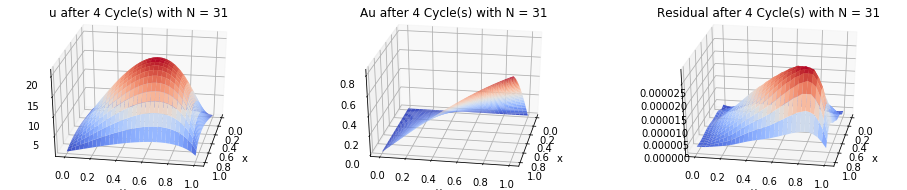

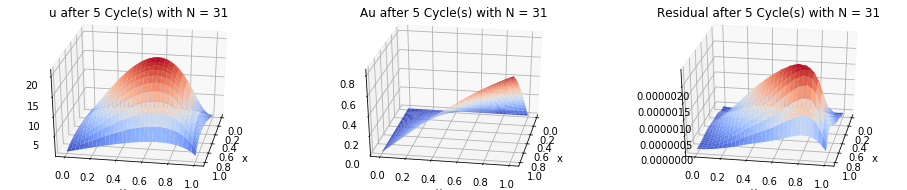

In [15]:
task1a(5, 5, 5, 10E-12, 5)

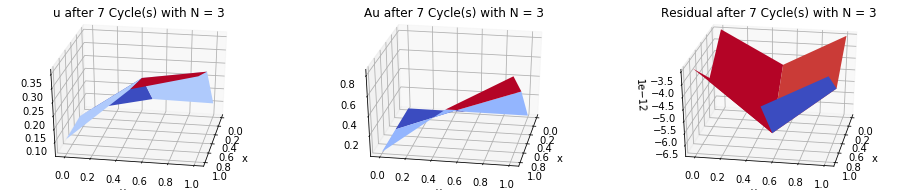

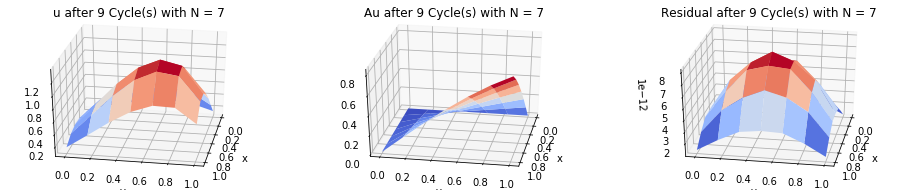

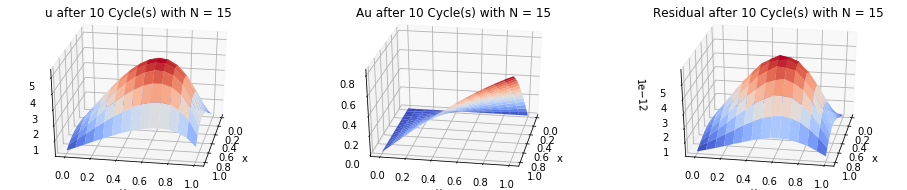

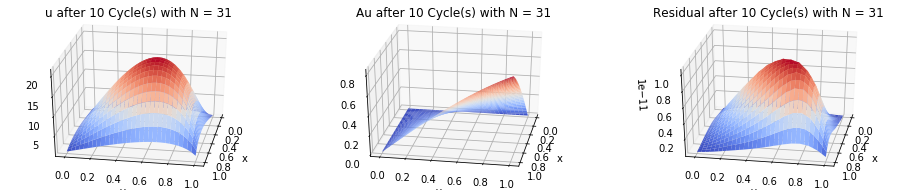

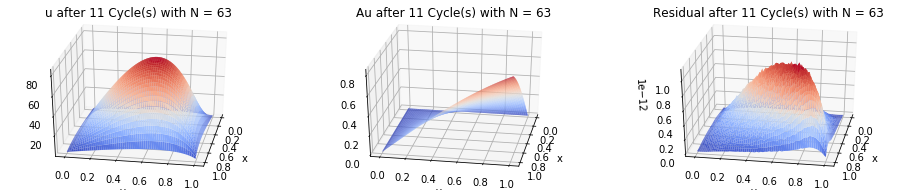

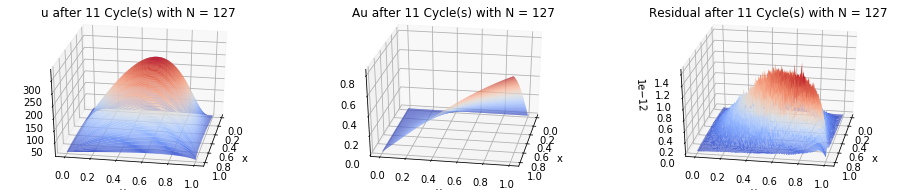

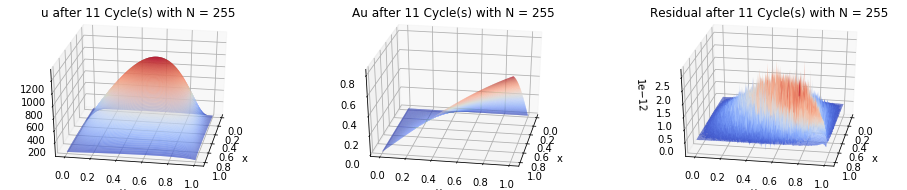

In [16]:
def task1b(nu1, nu2, tol, max_iter):
    f = lambda x,y: np.sin(x*y)
    L = [2, 3, 4, 5, 6, 7, 8]

    for l in L:
        N = 2**l-1
        x = np.linspace(0,1,N)
        y = np.linspace(0,1,N)
        rhs = np.zeros((N,N))
        u = np.random.rand(N,N)

        for i in range(N):
            for j in range(N):
                rhs[i,j] = f(x[i],y[j])

        r0 = np.linalg.norm(residual(u, rhs), 2)
        r = r0
        iterations = 0

        while r/r0 > tol and max_iter > iterations:
            u = mgv(u, rhs, nu1, nu2, 0, l-1)
            r = np.linalg.norm(residual(u, rhs), 2)
            iterations += 1

        plot(u, rhs, N, iterations)

        plt.show()

task1b(5,5,10E-12,200)

## Task 2

For this exercise, we wish to look at the power iteration method to find the largest eigenvalue of a Markov chain matrix. The power iteration will be

![title](poweriteration.png)

as described in _Numerical Linear Algebra_ by Treheften and Bau. To use this algorithm, we must first import a matrix $A$ that contains the Markov chain for the webpages at Stanford. Then, we normalize the columns of $A$ to get $B$. This is done by defining $k_{j} = \sum_{i=0}^N a_{ij}$ and $b_{ij} = a_{ij}/k_j$ for $0 \leq i,j \leq N$. We then introduce damping, by defining a matrix $M = (1-d) \frac{\bf{ee}^T}{N+1}+dB$, where $d$ is the damping term. In the code, I calculate $Mx$ directly, instead of figuring out what $M$ is seperatly. This is done by seeing that

$$Mx = M1 + M2 = (1-d) \frac{\bf{ee}^T}{N+1}x+dBx,$$

where $M1$ will be a vector where every element is the sum of all elements in $x$ multiplied with $\frac{1-d}{N+1}$. Then the power iteration can be implemented as

In [22]:
def power_iteration(d, tol):
    # Initializing variables
    A = scipy.io.mmread('stanford.mtx')
    N = A.get_shape()
    residuals = [1]
    r = 1
    iter = 0
    x0 = np.array(np.ones((N[0],1))) / (N[0])

    # Calculating B-matrix
    k = 1/sparse.csc_matrix.getnnz(A.tocsc(),axis=0)
    B = A.multiply(k)

    while r > tol:
        iter += 1

        M1 = (1-d)*sum(x0)*np.ones((N[0],1))/N[0]
        M2 = d * B.dot(x0)
        Mx = M1 + M2

        x = Mx / np.linalg.norm(Mx)
        r = np.linalg.norm(x - x0)
        residuals.append(r)
        x0 = x

    return x0, residuals, iter

If we choose $d=0.85$ and $tol=10^{-8}$, we get a convergence of the residuals like this

In [40]:
# Please give up to a minute for this to run
d = 0.85
tol = 1E-8
x, residuals, iter = power_iteration(d, tol)

Used 95 iterations to obtain a tolerance of 1e-08 

The most visited site has index [89072]


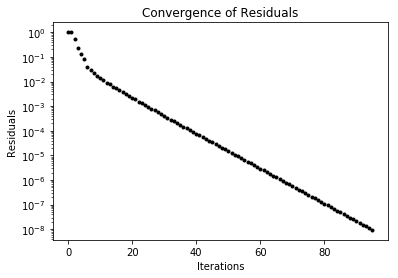

In [46]:
print('Used %d iterations to obtain a tolerance of %s' % (iter, tol), '\n')
print('The most visited site has index', (np.where(x == np.max(x)))[0])

iterations = np.linspace(0, iter, len(residuals))
plt.semilogy(iterations, residuals, 'k.')
plt.xlabel('Iterations')
plt.ylabel('Residuals')
plt.title('Convergence of Residuals')
plt.show()